## The following notebook details the process of developing and testing unique metrics I am hoping will predict both defensive pass rusher effectiveness, and offensive blocker effectiveness.  The first metrics explroed here are 'Pursuit Efficiency' and 'Chase Efficiency'.

## These first metrics seek to quantify how effectively a pass rusher is pursuing the ball.
- 'Pursuit Efficiency' indicates what percentage of the play their movement vector is going towards the ball as it moves.  It does not take into account the magnitude of their pursuit.
- The 'Chase Efficiency' metric adds in magnitude to the pursuit, and seeks to isolate the the pass rusher's pursuit of the ball independant of how the quarterback moves.  For example, if the quarterback is scrambling the other way, the rusher should not be penalized for that component of distance change.  Conversely, if the qb with ball moves closer to the player, the player will be getting closer but not necessarily be more of a threat.

#### The metric finds the movement vector of the player towards the ball every 0.1 seconds of play.

# -- SECTION 1: PROCESS WORKTHROUGH --

### Determine process for building the metrics for a single player (pass rusher) for a single play.

# I. Load Libraries

In [1]:
# Standard base libraries
import pandas as pd
import numpy as np

# Used for calculating pursuit/escape angle (part of the metric)
from scipy import spatial

# For plotting player movement
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Misc
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

# II. Load Data (as DataFrames)

In [ ]:
# Play outcome data
scout = pd.read_csv('data/pffScoutingData.csv')

# Player tracking data
w1 = pd.read_csv('data/week1.csv')

# III. Clean Data
- For details on this refer to the 'Data Review' notebook

### 1. Isolate and clean pass rusher scouting data

In [ ]:
# Isolate pass rushers
scout_pass_rush = scout[scout.pff_role == 'Pass Rush']

# Strip unnecessary columns, rename and retype
scout_pass_rush = scout_pass_rush[['gameId',
                                 'playId',
                                 'nflId',
                                 'pff_positionLinedUp',
                                 'pff_hit',
                                 'pff_hurry',
                                 'pff_sack',]].rename(columns = {'gameId':'game',
                                                                'playId':'play',
                                                                'pff_positionLinedUp':'position',
                                                                'pff_hit':'hit',
                                                                'pff_hurry':'hurry',
                                                                'pff_sack':'sack'}).astype({'hit':int,
                                                                                            'hurry':int,
                                                                                            'sack':int})

# Create a catch-all column for pressure
scout_pass_rush['pressure'] = scout_pass_rush.hit + scout_pass_rush.hurry + scout_pass_rush.sack

scout_pass_rush.head(2)

### 2. Load and clean weekly data

In [ ]:
# Choose week
week = w1

In [ ]:
week = week.drop(columns = ['time','playDirection','team','jerseyNumber']).rename(columns = {'gameId':'game',
                                                                       'playId':'play',
                                                                       'frameId':'frame',}).fillna(0).astype({'nflId':int})
                                                                                                               
week.head(2)

# IV. Create Object with games and plays in each game

##### Should use a dictionary for this, as found below:

In [ ]:
# game_plays = {}
# for game in week.game.unique():
#     print(game)
#     plays = []
#     for play in week[week.game == game].play.unique():
#         plays.append(play)
#     game_plays[game] = plays

In [ ]:
# Then pull individual plays using this
# game = 2021091208

# for plays in game_plays[game]:
#     print(plays)

*Can also use a multilevel index for this.  TBD.*

#### For now will create a list of (game, play) tuples:

In [ ]:
week_game_plays = []
for game in week.game.unique():
    for play in week[week.game == game].play.unique():
        week_game_plays.append((game,play))

# V. For a select play in a select game, create football and player dataframes

### 1. Create a dataframe with scouting data for pass rushers on selected play only and then create list of players

##### For testing - create random variables to test game and play

In [ ]:
# 1175 passing plays in week 1 across 16 games
game_index = np.random.randint(0,1174)

game = week_game_plays[game_index][0]
play = week_game_plays[game_index][1]

game, play

In [ ]:
# Determine pass rushers on this play
scout_play = scout_pass_rush[scout_pass_rush.game == game][scout_pass_rush.play == play]
scout_play

Select a random pass rusher from this play:

In [ ]:
pass_rushers = list(scout_play.nflId)
pass_rusher = np.random.choice(pass_rushers)
pass_rusher

### 2. Create dataframe with 0.1s frame data for selected play only

In [ ]:
# Creates dataframe for single play from single game
play_frames = week[week.game == game][week.play == play]

### 3. Pull out football frames, get initial x (line of scrimmage) and then truncate from ball snap to end event
- Note: 'End event' is when the pass rusher stops pursuing the qb/ball in the backfield as the ball has been passes, the qb has taken off on a run, or tehre is a sack or other event that ends their role as a pass rusher.

In [ ]:
# Creates football frame data for play
football_frames = play_frames[play_frames.nflId ==0].set_index('frame',drop = True)

In [ ]:
# Get the x value for the line of scrimmage (for use with play graphing)
line_of_scrimmage = football_frames.x.iloc[0]
line_of_scrimmage

In [ ]:
trigger = 0

for i, event in enumerate(football_frames.event):
    # If the event is a ball_snap, stores the snap index and triggers the function to start checking events
    if event == 'ball_snap':
        snap_index = i + 1
        trigger = 1
        continue

    if trigger == 1:
        # The following events are not end events
        if event in ['None','autoevent_ballsnap','autoevent_passforward','play_action','first_contact','shift','man_in_motion','line_set']:
            continue
        # If the trigger is on and the event is an end event, return the index
        else:
            end_index = i + 1
    else:
        continue

In [ ]:
snap_index, end_index

In [ ]:
# Use the frame index to remove unecessary frames from the play (pre-snap and post pass event)
football_frames = football_frames[(football_frames.index >= snap_index) & (football_frames.index <= end_index)]

In [ ]:
#  Removing unecessary columns and renaming things
football_frames = football_frames.drop(columns = ['game',
                                      'play',
                                      'nflId',
                                      'o',
                                      'dir',
                                      'event']).rename(columns = {'x':'ball_x',
                                                                 'y':'ball_y',
                                                                 's':'ball_s',
                                                                 'a':'ball_a',
                                                                 'dis':'ball_dis'})

#### Merging the pass rusher with the football frames

In [ ]:
pass_rusher_play = football_frames.merge(play_frames[play_frames.nflId == pass_rusher].set_index('frame',drop = True),
                                        on = 'frame', how = 'left').reset_index(drop = True)

# VI. Creation of Metric and supporting/intermediate features

### 1. Find the distance between player and ball at any given frame

In [ ]:
# Simply use pythagorean formula to calculate distance at time of frame based on x and y coordinates
pass_rusher_play['ball_player_distance'] = ((pass_rusher_play.x - pass_rusher_play.ball_x)**2 +
                                (pass_rusher_play.y - pass_rusher_play.ball_y)**2)**.5

In [ ]:
# Since the previous locations are required for the calculation of the metric later on, create a column with previous distance
pass_rusher_play['prev_distance'] = pass_rusher_play.ball_player_distance.shift(1)

### 2. Find the angles between the ball and the player movement vectors

In [ ]:
# Shifting the x and y allows to compare past coordinate location to present, giving us a movement vector
pass_rusher_play['shift_x'] = pass_rusher_play.x.shift(1)

pass_rusher_play['shift_y'] = pass_rusher_play.y.shift(1)

In [ ]:
# I am sure there is a way to calcualte directly in the dataframe using assign, but this calcualtes the angle between 
# the player and the ball after they both move, and the direction the player actually moved in that interval.  A 
# negative value means the player is moving in a direction away from the ball; a zero (0) value means they are moving 
# perpendicular to it; for positive values, the closer to one the more direct the movement - a value of one means 
# they move directly towards the ball in that interval.

# Need to initialize with a value to account for the shift, this frame will later be dropped
pursuit_angle_factor = [[0,0]]

for i in pass_rusher_play.index[1:]:
    pursuit_angle_factor.append(
        1 - spatial.distance.cosine(
            [round(pass_rusher_play.x.iloc[i]-pass_rusher_play.shift_x.iloc[i],3),
            round(pass_rusher_play.y.iloc[i]-pass_rusher_play.shift_y.iloc[i],3)],
            [round(pass_rusher_play.ball_x.iloc[i]-pass_rusher_play.shift_x.iloc[i],3),
            round(pass_rusher_play.ball_y.iloc[i]-pass_rusher_play.shift_y.iloc[i],3)]))

# Add this list as a dataframe column
pass_rusher_play['pursuit_factor'] = pursuit_angle_factor

In [ ]:
# Shifting the x and y for the ball as well to get its movement vector
pass_rusher_play['shift_ball_x'] = pass_rusher_play.ball_x.shift(1)

pass_rusher_play['shift_ball_y'] = pass_rusher_play.ball_y.shift(1)

In [ ]:
# Need to initialize with a value to account for the shift
escape_angle_factor = [[0,0]]

for i in pass_rusher_play.index[1:]:
    escape_angle_factor.append(
        1 - spatial.distance.cosine(
            [round(pass_rusher_play.ball_x.iloc[i]-pass_rusher_play.shift_ball_x.iloc[i],3),
            round(pass_rusher_play.ball_y.iloc[i]-pass_rusher_play.shift_ball_y.iloc[i],3)],
            [round(pass_rusher_play.x.iloc[i]-pass_rusher_play.shift_ball_x.iloc[i],3),
            round(pass_rusher_play.y.iloc[i]-pass_rusher_play.shift_ball_y.iloc[i],3)]))

# Add this list as a dataframe column
pass_rusher_play['escape_factor'] = escape_angle_factor

In [ ]:
# For reference
pass_rusher_play['distance_proportion'] = pass_rusher_play['ball_player_distance']/pass_rusher_play['prev_distance']

Dropping the first and last frames (otherwise future columns have issues with NaN values)

In [ ]:
pass_rusher_play = pass_rusher_play[1:-1]

### 3. Create the player and ball movement vectors

In [ ]:
pass_rusher_play['pursuit'] = pass_rusher_play.dis * pass_rusher_play.pursuit_factor
pass_rusher_play['escape'] = pass_rusher_play.ball_dis * -pass_rusher_play.escape_factor

In [ ]:
pass_rusher_play['true_pursuit'] = pass_rusher_play.pursuit + pass_rusher_play.escape

In [ ]:
pass_rusher_play['metric'] = (pass_rusher_play.prev_distance + pass_rusher_play.true_pursuit)/(pass_rusher_play.ball_player_distance)

In [ ]:
pass_rusher_play

Clean up play to drop all columns uninvoled with creating the metric:

In [ ]:
pass_rusher_play_metric = pass_rusher_play.drop(columns = ['ball_s','ball_a','game','play','s','a','o','dir','event','distance_proportion'])

In [ ]:
pass_rusher_play_metric.head()

Now to find the mean of the metric for the play, which is the actual game-play metric to be cumulated as part of the overall player's metric rating.

Then pull in the scouting report to see how if there was a block fail/pressure

In [ ]:
print(f'Play pursuit factor: {pass_rusher_play_metric.pursuit_factor.mean():.3}')
print(f'Play metric: {pass_rusher_play_metric.metric.mean():.3}')
print(f'Pass Rusher Details:')
scout_pass_rush[scout_pass_rush.game == game][scout_pass_rush.play == play][scout_pass_rush.nflId == pass_rusher]

### 4. Graph the play to compare to the metric

In [ ]:
# ToDo - Make each point for the player a vector facing the ball?
pass_rusher_analysis_frames = pass_rusher_play.copy()

plt.figure(figsize = [9,9])
plt.title('---- Pass Rusher (red) vs. Ball (green) by Frame ----\nFrames go from Light (snap) to Dark (end of play)', fontsize = 16)
plt.xlabel('Absolute Yardline')
plt.ylabel('')

# Create and graph the datapoints
sns.scatterplot(x = pass_rusher_analysis_frames.ball_x, y = pass_rusher_analysis_frames.ball_y, hue = pass_rusher_analysis_frames.index, palette = 'Greens', legend = False)
sns.scatterplot(x = pass_rusher_analysis_frames.x, y = pass_rusher_analysis_frames.y, hue = pass_rusher_analysis_frames.index, palette = 'Reds', legend = False)

# Create the frame lables for the player
for mark in zip(pass_rusher_analysis_frames.index,pass_rusher_analysis_frames.x,pass_rusher_analysis_frames.y):
    plt.annotate(mark[0],
                (mark[1], mark[2]),
                textcoords = 'offset points',
                xytext = (4,4),
                ha = 'center',
                fontsize = 8)
# Create the frame labels for the football
for mark in zip(pass_rusher_analysis_frames.index,pass_rusher_analysis_frames.ball_x,pass_rusher_analysis_frames.ball_y):
    plt.annotate(mark[0],
                (mark[1], mark[2]),
                textcoords = 'offset points',
                xytext = (4,4),
                ha = 'center',
                fontsize = 8)

# At figsize = [12,12], the line width of the line of scrimmage = 19.2; change in proportion to this
plt.axvline(x = line_of_scrimmage,
            lw = 14.4,
            alpha = 0.2)
plt.axvline(x = line_of_scrimmage)
plt.text(line_of_scrimmage, (pass_rusher_analysis_frames.ball_y.mean() + pass_rusher_analysis_frames.y.mean())/2, 
        f'Line of Scrimmage\n~{int(line_of_scrimmage)} yard line',
        fontsize = 15, rotation = 90,
        ha = 'center',
        va = 'top')

plt.show()

---
# -- SECTION 2: FUNCTION DEVELOPMENT AND TESTING --

# I. Load Python function library

In [2]:
import nfl_functions as nf
import nfl_acquire_and_prep as acquire

# Needed to select random player
import numpy as np

# II. Acquire and return cleaning data

Test acquisition of dataframes not used in this metric creation:

In [ ]:
games_df = acquire.games()
# Checks out

In [ ]:
players_df = acquire.players()
# Checks out

In [ ]:
plays_df = acquire.plays()
# Checks out

In [ ]:
week_fail = acquire.week(12)
# Checks out

In [ ]:
pass_blockers_df = acquire.scout_pass_block()
# Checks out

In [3]:
pass_rushers_df = acquire.scout_pass_rush()

week_df = acquire.week(1)

Create a random play to analyze:

In [4]:
game, play = nf.random_play(week_df)
game, play

(2021091213, 514)

For testing specific play:

In [ ]:
# game = 2021091200
# play = 2631
# pass_rusher = 46416

# III. Build Analysis Frame(s)

In [5]:
# game and play are from above
play_pass_rush = nf.get_play_pass_rushers(pass_rushers_df, game, play)
play_pass_rush

,game,play,nflId,position,hit,hurry,sack,pressure
22619,2021091213,514,37087,REO,0,1,0,1
22620,2021091213,514,38619,DLT,0,0,0,0
22623,2021091213,514,41231,LOLB,0,0,0,0
22626,2021091213,514,43456,SCBL,0,0,0,0
22632,2021091213,514,46214,DRT,0,0,0,0


Get the play and frames

In [6]:
play_frames = nf.get_play_frames(week_df, game, play)
play_frames

,game,play,nflId,frame,x,y,s,a,dis,o,dir,event
974740,2021091213,514,30869,1,49.85,33.16,0.00,0.00,0.00,98.69,226.59,None
974741,2021091213,514,30869,2,49.85,33.16,0.00,0.00,0.00,98.69,230.14,man_in_motion
974742,2021091213,514,30869,3,49.85,33.16,0.00,0.00,0.00,98.69,267.87,None
974743,2021091213,514,30869,4,49.85,33.16,0.00,0.00,0.00,98.69,274.27,None
974744,2021091213,514,30869,5,49.85,33.17,0.00,0.00,0.00,96.99,309.23,None
...,...,...,...,...,...,...,...,...,...,...,...,...
975908,2021091213,514,0,47,42.96,16.87,18.15,0.21,2.39,0.00,0.00,None
975909,2021091213,514,0,48,44.53,15.96,18.08,1.16,1.81,0.00,0.00,None
975910,2021091213,514,0,49,46.09,15.06,17.93,1.99,1.80,0.00,0.00,None
975911,2021091213,514,0,50,47.63,14.17,17.69,2.70,1.78,0.00,0.00,None


In [7]:
line_of_scrimmage, football_frames = nf.play_fb_frames(play_frames)
print(f'Line of Scrimmage: {line_of_scrimmage}')
football_frames

Line of Scrimmage: 50.6


,ball_x,ball_y,ball_s,ball_a,ball_dis
frame,,,,,
6,50.11,29.80,0.03,0.03,0.23
7,49.81,29.85,0.06,0.00,0.30
8,49.66,29.89,0.07,0.01,0.16
9,49.62,29.89,0.08,0.03,0.03
10,49.52,29.92,0.10,0.07,0.11
11,49.47,29.94,0.20,1.60,0.05
12,49.37,29.96,0.49,3.03,0.10
13,49.31,29.98,0.79,2.80,0.06
14,49.15,30.02,1.49,3.99,0.17


In [8]:
pass_rusher = np.random.choice(play_pass_rush.nflId)
pass_rusher

43456

In [9]:
pass_rusher_analysis_frames = nf.create_pass_rusher_analysis_frames(football_frames, play_frames, pass_rusher)
pass_rusher_analysis_frames

,ball_x,ball_y,ball_s,ball_a,ball_dis,game,play,nflId,x,y,s,a,dis,o,dir,event
0,50.11,29.80,0.03,0.03,0.23,2021091213,514,43456,54.01,23.81,1.22,1.76,0.13,300.77,8.81,ball_snap
1,49.81,29.85,0.06,0.00,0.30,2021091213,514,43456,54.01,23.92,1.04,2.69,0.11,299.90,347.89,None
2,49.66,29.89,0.07,0.01,0.16,2021091213,514,43456,53.96,24.01,1.00,3.07,0.10,305.22,324.85,None
3,49.62,29.89,0.08,0.03,0.03,2021091213,514,43456,53.86,24.06,1.21,3.92,0.11,296.70,290.60,None
4,49.52,29.92,0.10,0.07,0.11,2021091213,514,43456,53.70,24.07,1.69,4.49,0.16,300.94,272.73,None
5,49.47,29.94,0.20,1.60,0.05,2021091213,514,43456,53.50,24.07,2.20,4.49,0.20,291.91,266.30,None
6,49.37,29.96,0.49,3.03,0.10,2021091213,514,43456,53.25,24.05,2.66,4.01,0.25,290.58,263.51,None
7,49.31,29.98,0.79,2.80,0.06,2021091213,514,43456,52.95,24.04,3.13,3.62,0.30,287.52,265.04,None
8,49.15,30.02,1.49,3.99,0.17,2021091213,514,43456,52.62,24.01,3.55,3.34,0.34,293.31,266.48,None
9,48.99,30.06,1.90,4.26,0.17,2021091213,514,43456,52.25,24.01,3.84,2.96,0.37,293.31,270.54,None


# IV. Create Metric

In [12]:
pass_rusher_analysis_frames = nf.pass_rusher_game_play_metric_frames(pass_rusher_analysis_frames)
pass_rusher_analysis_frames

,ball_x,ball_y,ball_dis,nflId,x,y,dis,ball_player_distance,prev_distance,shift_x,shift_y,shift_ball_x,shift_ball_y,pursuit_factor,escape_factor,pursuit,escape,true_pursuit,metric
1,49.81,29.85,0.30,43456,54.01,23.92,0.11,7.266698,7.147734,54.01,23.81,50.11,29.80,0.821016,-0.682219,0.090312,0.204666,0.294977,1.024222
2,49.66,29.89,0.16,43456,53.96,24.01,0.10,7.284532,7.266698,54.01,23.92,49.81,29.85,0.992495,-0.76973,0.099249,0.123157,0.222406,1.028083
3,49.62,29.89,0.03,43456,53.86,24.06,0.11,7.208779,7.284532,53.96,24.01,49.66,29.89,0.890974,-0.584525,0.098007,0.017536,0.115543,1.026536
4,49.52,29.92,0.11,43456,53.70,24.07,0.16,7.189917,7.208779,53.86,24.06,49.62,29.89,0.64413,-0.78511,0.103061,0.086362,0.189423,1.028969
5,49.47,29.94,0.05,43456,53.50,24.07,0.20,7.120239,7.189917,53.70,24.07,49.52,29.92,0.584632,-0.829335,0.116926,0.041467,0.158393,1.032031
6,49.37,29.96,0.10,43456,53.25,24.05,0.25,7.069830,7.120239,53.50,24.07,49.47,29.94,0.506993,-0.69467,0.126748,0.069467,0.196215,1.034884
7,49.31,29.98,0.06,43456,52.95,24.04,0.30,6.966577,7.069830,53.25,24.05,49.37,29.96,0.525347,-0.761511,0.157604,0.045691,0.203295,1.044003
8,49.15,30.02,0.17,43456,52.62,24.01,0.34,6.939813,6.966577,52.95,24.04,49.31,29.98,0.457712,-0.682533,0.155622,0.116031,0.271653,1.043001
9,48.99,30.06,0.17,43456,52.25,24.01,0.37,6.872416,6.939813,52.62,24.01,49.15,30.02,0.514496,-0.66028,0.190363,0.112248,0.302611,1.05384
10,48.78,30.11,0.21,43456,51.85,24.03,0.40,6.811116,6.872416,52.25,24.01,48.99,30.06,0.537239,-0.626158,0.214896,0.131493,0.346389,1.059856


In [13]:
player_play_metric = nf.player_play_metric(pass_rusher_analysis_frames, return_pursuit_angle = True)
player_play_metric

(1.0936989446603624, 0.7930791247625136)

---
# -- SECTION 3: ITERATIVE DEVELOPMENT --

# I. Single Player, Single Play (to include play graphing)

In [45]:
# Need a game, play, and player
game, play = nf.random_play(week_df)
play_pass_rush = nf.get_play_pass_rushers(pass_rushers_df, game, play)
pass_rusher = np.random.choice(play_pass_rush.nflId)

In [54]:
def player_play_analysis(pass_rushers_df, week_df, pass_rusher, game, play, return_graph = False, return_pursuit_angle = True):
    '''
    Create a single player analysis
    '''
    # Isolate player
    play_pass_rushers = nf.get_play_pass_rushers(pass_rushers_df, game, play)
    play_pass_rusher = play_pass_rushers[play_pass_rushers.nflId == pass_rusher]

    play_frames_df = nf.get_play_frames(week_df, game, play)

    line_of_scrimmage, football_frames_df = nf.play_fb_frames(play_frames_df)

    pass_rusher_analysis_frames = nf.create_pass_rusher_analysis_frames(football_frames_df, play_frames_df, pass_rusher)

    pass_rusher_analysis_frames =  nf.pass_rusher_game_play_metric_frames(pass_rusher_analysis_frames)

    metric = nf.player_play_metric(pass_rusher_analysis_frames, return_pursuit_angle = return_pursuit_angle)

    if return_pursuit_angle == True:
            play_metric = metric[0]
            play_pursuit_angles = metric[1]

    else:
        play_metric = metric

    # Optional Graph
    if return_graph == True:
        nf.create_single_player_graph(pass_rusher_analysis_frames, line_of_scrimmage)
    
    player_metrics = {'Player':play_pass_rusher.nflId,'Metrics':play_metric, 'Hit':play_pass_rusher.hit, 'Hurry':play_pass_rusher.hurry, 'Sack':play_pass_rusher.sack, 'Pressure':play_pass_rusher.pressure}

    if return_pursuit_angle == True:
        player_metrics['Pursuit Angle'] = play_pursuit_angles

    return line_of_scrimmage, pass_rusher_analysis_frames, player_metrics

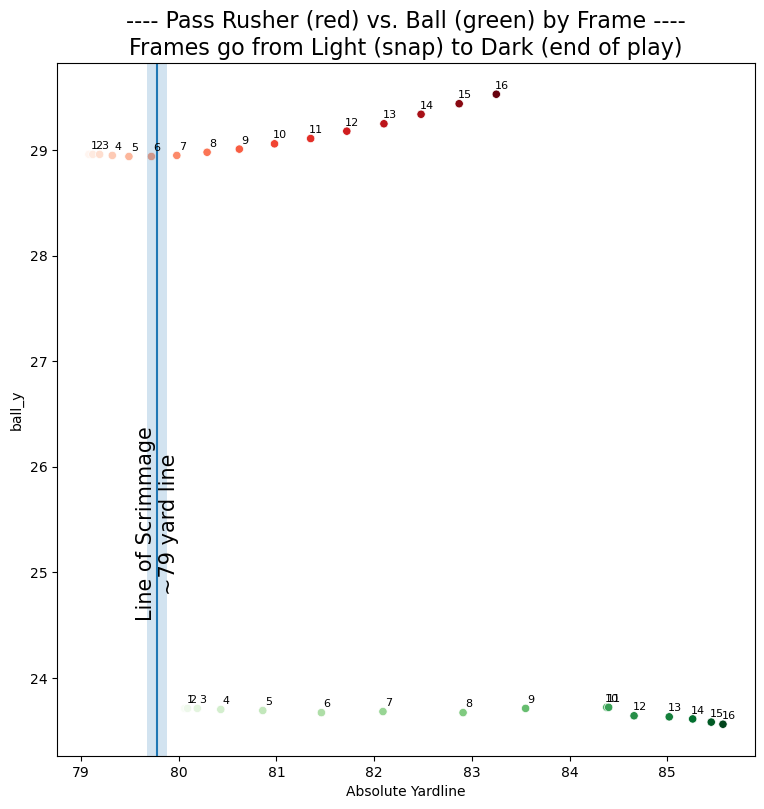

(79.78,
     ball_x  ball_y  ball_dis  nflId      x      y   dis  ball_player_distance  \
 1    80.06   23.71      0.06  53479  79.08  28.96  0.02              5.340683   
 2    80.09   23.71      0.03  53479  79.12  28.96  0.04              5.338858   
 3    80.19   23.71      0.10  53479  79.19  28.96  0.07              5.344390   
 4    80.43   23.70      0.24  53479  79.32  28.95  0.12              5.366060   
 5    80.86   23.69      0.43  53479  79.49  28.94  0.17              5.425809   
 6    81.46   23.67      0.60  53479  79.72  28.94  0.23              5.549820   
 7    82.09   23.68      0.63  53479  79.98  28.95  0.27              5.676707   
 8    82.91   23.67      0.82  53479  80.29  28.98  0.31              5.921191   
 9    83.55   23.71      0.65  53479  80.62  29.01  0.33              6.055981   
 10   84.38   23.72      0.83  53479  80.98  29.06  0.36              6.330529   
 11   84.40   23.72      0.02  53479  81.35  29.11  0.37              6.193109   
 12   84

In [55]:
line_of_scrimmage, pass_rusher_analysis_frames, player_metrics = player_play_analysis(pass_rushers_df, week_df, pass_rusher, game, play, return_graph = True)
line_of_scrimmage, pass_rusher_analysis_frames, player_metrics

In [48]:
pd.DataFrame(player_metrics)

,Player,Metrics,Hit,Hurry,Sack,Pressure,Pursuit Angle
21471,53479,1.023661,0,0,0,0,0.316349


# II. All players in a play (to include play graphing)

In [106]:
def create_play_graph(line_of_scrimmage, graph_ids, graph_input, ball_graph_input):
    '''
    Creates a graph of all pass rushers on a given play
    '''
     # Import graphics libraries
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    # Create figure
    plt.figure(figsize = [9,9])
    plt.title('---- Pass Rusher (red) vs. Ball (green) by Frame ----\nFrames go from Light (snap) to Dark (end of play)', fontsize = 16)
    plt.xlabel('Absolute Yardline')
    plt.ylabel('')
    
    # Create and graph the datapoints
    sns.scatterplot(x = ball_graph_input.ball_x, y = ball_graph_input.ball_y, hue = ball_graph_input.index, palette = 'Greens', legend = False)
    sns.scatterplot(x = graph_input.x, y = graph_input.y, hue = graph_input.index, palette = 'Reds', legend = False)
   
    # Create the frame labels for the players
    for mark in zip(graph_input.index,graph_input.x,graph_input.y):
        plt.annotate(mark[0],
                    (mark[1], mark[2]),
                    textcoords = 'offset points',
                    xytext = (4,4),
                    ha = 'center',
                    fontsize = 8)

    # Create the frame labels for the football
    for mark in zip(ball_graph_input.index,ball_graph_input.ball_x,ball_graph_input.ball_y):
        plt.annotate(mark[0],
                    (mark[1], mark[2]),
                    textcoords = 'offset points',
                    xytext = (4,4),
                    ha = 'center',
                    fontsize = 8)
        
    # Create the labels to identify which rusher is whom
    for identity in graph_ids:
        plt.annotate(identity,
                    (graph_ids[identity][0],graph_ids[identity][1]),
                    textcoords = 'offset points',
                    xytext = (-8,-4),
                    ha = 'right',
                    fontsize = 12)
 
    # At figsize = [12,12], the line width of the line of scrimmage = 19.2; change in proportion to this
    plt.axvline(x = line_of_scrimmage,
                lw = 14.4,
                alpha = 0.2)
    plt.axvline(x = line_of_scrimmage)
    plt.text(line_of_scrimmage, (ball_graph_input.ball_y.mean() + graph_input.y.mean())/2, 
            f'Line of Scrimmage\n~{int(line_of_scrimmage)} yard line',
            fontsize = 15, rotation = 90,
            ha = 'center',
            va = 'top')

    plt.show()

In [114]:
def play_analysis(pass_rushers_df, week_df, game, play, return_graph = False, return_pursuit_angle = True):
    '''
    Emits a dataframe with each pass rushers metric for the play, along with the outcome from the scouting report.
    '''
    play_pass_rush = nf.get_play_pass_rushers(pass_rushers_df, game, play)

    # The data structure to hold the metric results
    play_metrics = pd.DataFrame()
    
    # The data structure to hold the graphing coordiantes
    graph_input = pd.DataFrame()
    
    # The data structure to hold the ids for the graph
    graph_ids = {}
    
    for pass_rusher in play_pass_rush.nflId:
        line_of_scrimmage, pass_rusher_analysis_frames, player_metrics = player_play_analysis(pass_rushers_df, week_df, pass_rusher, game, play, return_pursuit_angle = return_pursuit_angle)
        
        player_metrics = pd.DataFrame(player_metrics)
        
        play_metrics = pd.concat([play_metrics, player_metrics])
        
        graph_input = pd.concat([graph_input, pass_rusher_analysis_frames[['x','y']]])
        
        graph_ids[pass_rusher] = [pass_rusher_analysis_frames.x.iloc[0],pass_rusher_analysis_frames.y.iloc[0]]

    # Now get the ball data
    ball_graph_input = pass_rusher_analysis_frames[['ball_x','ball_y']]
    
    if return_graph == True:
        create_play_graph(line_of_scrimmage, graph_ids, graph_input, ball_graph_input)
    
    return play_metrics

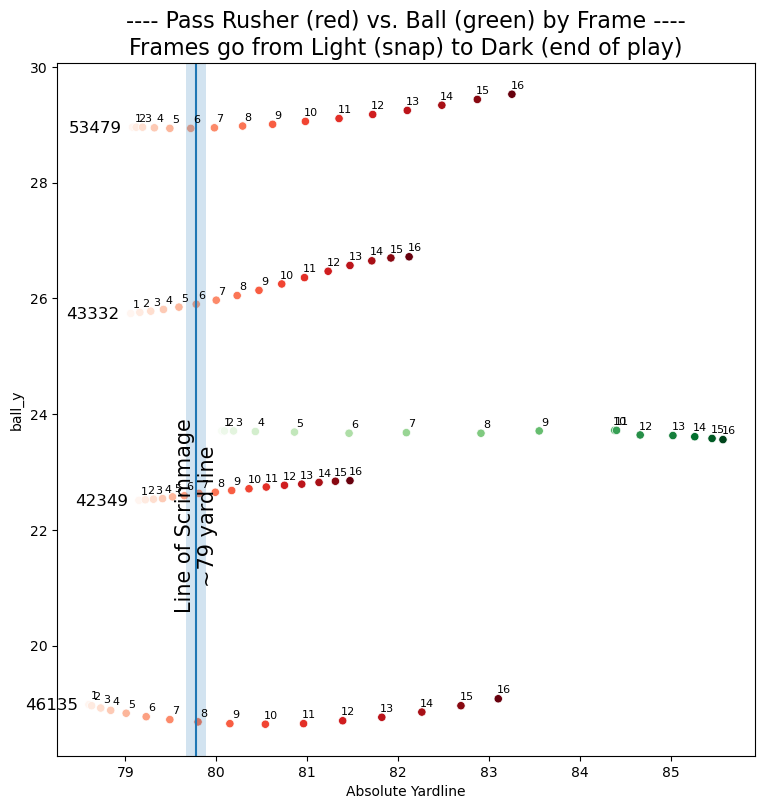

In [108]:
play_metrics = play_analysis(pass_rushers_df, week_df, game, play, return_graph = True, return_pursuit_angle = True)

In [109]:
play_metrics

,Player,Metrics,Hit,Hurry,Sack,Pressure,Pursuit Angle
21453,42349,1.088702,0,0,0,0,0.930253
21455,43332,1.042965,0,0,0,0,0.462072
21462,46135,1.049250,0,0,0,0,0.370590
21471,53479,1.023661,0,0,0,0,0.316349


# III. Game metrics

In [115]:
def game_analysis(pass_rushers_df, week_df, game, return_pursuit_angle = True, grouped = False):
    '''
    Emits a dataframe with each pass rushers metric for the game, along with the outcome from the scouting report.
    '''
    game_plays = nf.plays_by_game(week_df)
    plays = game_plays[game]

    game_metrics = pd.DataFrame()

    for play in plays:

        # Added a try except since there are errors when the snap events are missing
        try:
            play_metrics = pd.DataFrame(play_analysis(pass_rushers_df, week_df, game, play, return_pursuit_angle = return_pursuit_angle))

            game_metrics = pd.concat([game_metrics, play_metrics])
        
        except:
            print('Error loading (game, play):',game, play)

    # Note, if looking to analyze single game, this will emit a pre-grouped dataframe
    if grouped == True:
        play_count = list(game_metrics.groupby(by = 'Player').Player.count())

        game_metrics = game_metrics.groupby(by = 'Player').mean()

        game_metrics['play_count'] = play_count

    return game_metrics

In [117]:
game_metrics = game_analysis(pass_rushers_df, week_df, game, return_pursuit_angle = True, grouped = False)
game_metrics

In [119]:
game_metrics = game_analysis(pass_rushers_df, week_df, game, return_pursuit_angle = True, grouped = True)
game_metrics

,Metrics,Hit,Hurry,Sack,Pressure,Pursuit Angle,play_count
Player,,,,,,,
37075,1.117704,0.040000,0.120000,0.080000,0.240000,0.686064,25
40031,1.133075,0.200000,0.000000,0.200000,0.400000,0.642312,5
40347,1.055122,0.000000,0.076923,0.000000,0.076923,0.564397,13
41449,1.064012,0.000000,0.000000,0.000000,0.000000,0.654104,11
41464,1.060895,0.000000,0.090909,0.000000,0.090909,0.641508,22
42349,1.079812,0.033333,0.133333,0.000000,0.166667,0.712574,30
42355,1.069266,0.000000,0.100000,0.000000,0.100000,0.731796,10
42826,1.049484,0.000000,0.181818,0.000000,0.181818,0.601780,11
42935,1.093205,0.000000,1.000000,0.000000,1.000000,0.698071,1


# IV. League-Wide Weekly Metrics

In [127]:
def week_analysis(week_df, pass_rushers_df):
    '''
    
    '''
    week_game_plays = nf.plays_by_game(week_df)
    
    games = week_game_plays.keys()
    
    week_metrics = pd.DataFrame()
    
    for game in games:
 
        game_metrics = pd.DataFrame(game_analysis(pass_rushers_df, week_df, game))

        week_metrics = pd.concat([week_metrics, game_metrics])        

    return week_metrics    

In [128]:
week_metrics = week_analysis(week_df, pass_rushers_df)

Error loading (game, play): 2021091200 4367
Error loading (game, play): 2021091202 3606
Error loading (game, play): 2021091206 1296


In [129]:
week_metrics

,Player,Metrics,Hit,Hurry,Sack,Pressure,Pursuit Angle
6,41263,1.144389,0,1,0,1,0.801541
8,42403,1.130225,0,1,0,1,0.879098
14,44955,1.025306,0,0,0,0,0.213181
20,53441,1.178157,0,1,0,1,0.925952
21,53504,1.111619,0,1,0,1,0.753346
...,...,...,...,...,...,...,...
25829,37240,1.074888,0,0,0,0,0.932389
25830,40042,1.085162,0,0,0,0,0.984621
25840,46259,1.148532,0,0,0,0,0.917517
25846,52506,1.097271,0,0,0,0,0.907080


In [131]:
# Check on the games that failed the algorithm
#week[week.game == 2021091200][week.play == 4367][week.nflId == 0]
#week[week.game == 2021091202][week.play == 3606][week.nflId == 0]
week_df[week_df.game == 2021091206][week_df.play == 1296][week_df.nflId == 33107]

# All of these are missing a 'ball snap' event.  Ok to drop since they are such a small number of plays

,game,play,nflId,frame,x,y,s,a,dis,o,dir,event
555266,2021091206,1296,33107,1,68.35,19.58,1.54,2.24,0.15,231.69,183.07,None
555267,2021091206,1296,33107,2,68.35,19.42,1.75,1.89,0.17,226.26,180.85,None
555268,2021091206,1296,33107,3,68.37,19.23,1.98,1.38,0.19,225.58,176.59,None
555269,2021091206,1296,33107,4,68.40,19.03,2.06,0.93,0.20,231.25,171.42,None
555270,2021091206,1296,33107,5,68.46,18.83,2.06,1.07,0.20,231.25,165.41,None
555271,2021091206,1296,33107,6,68.53,18.64,2.07,1.25,0.21,230.58,159.94,None
555272,2021091206,1296,33107,7,68.64,18.45,2.07,1.59,0.21,226.69,151.19,None
555273,2021091206,1296,33107,8,68.77,18.28,2.08,1.87,0.22,227.76,143.17,None
555274,2021091206,1296,33107,9,68.92,18.13,2.08,1.97,0.21,226.83,134.88,None
555275,2021091206,1296,33107,10,69.09,17.99,2.12,1.73,0.22,226.08,128.66,None


In [134]:
# First thing to do is remove low outliers - basically folks who haven't met a play threshold.
week_metrics.describe()

,Player,Metrics,Hit,Hurry,Sack,Pressure,Pursuit Angle
count,4988.000000,4988.000000,4988.000000,4988.000000,4988.000000,4988.000000,4988.000000
mean,44848.625902,1.078908,0.025862,0.079391,0.014635,0.119888,0.659718
std,4912.502105,0.051536,0.158740,0.270374,0.120099,0.324863,0.249384
min,33131.000000,0.873607,0.000000,0.000000,0.000000,0.000000,-0.723181
25%,42346.000000,1.048841,0.000000,0.000000,0.000000,0.000000,0.544610
50%,44871.000000,1.073580,0.000000,0.000000,0.000000,0.000000,0.710451
75%,47809.000000,1.100262,0.000000,0.000000,0.000000,0.000000,0.843661
max,53957.000000,1.541994,1.000000,1.000000,1.000000,1.000000,0.996580


##### Create a grouping function

In [133]:
def group_results(metrics_df):
    '''
    
    '''
    play_count = list(metrics_df.groupby(by = 'Player').Player.count())

    metrics_df = metrics_df.groupby(by = 'Player').mean()

    metrics_df['play_count'] = play_count

    return metrics_df

In [138]:
week_metrics_grouped = group_results(week_metrics)
week_metrics_grouped.describe()

,Metrics,Hit,Hurry,Sack,Pressure,Pursuit Angle,play_count
count,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000
mean,1.084350,0.031303,0.086853,0.015465,0.133621,0.679778,11.493088
std,0.033289,0.099027,0.166293,0.055550,0.192999,0.141720,10.152473
min,0.979146,0.000000,0.000000,0.000000,0.000000,-0.322019,1.000000
25%,1.063176,0.000000,0.000000,0.000000,0.000000,0.614101,3.000000
50%,1.080443,0.000000,0.000000,0.000000,0.078462,0.682586,9.000000
75%,1.097413,0.022997,0.111111,0.000000,0.190476,0.759111,18.000000
max,1.241842,1.000000,1.000000,0.500000,1.000000,0.993617,45.000000


In [141]:
week_metrics_grouped[week_metrics_grouped.play_count >3].sort_values(by = 'Pressure', ascending = False).head(20)

,Metrics,Hit,Hurry,Sack,Pressure,Pursuit Angle,play_count
Player,,,,,,,
52556,1.117304,0.000000,0.600000,0.000000,0.600000,0.615287,5
52436,1.195296,0.000000,0.250000,0.250000,0.500000,0.809971,4
53587,1.091791,0.142857,0.142857,0.142857,0.428571,0.682672,7
47795,1.144665,0.166667,0.250000,0.000000,0.416667,0.812279,12
40031,1.133075,0.200000,0.000000,0.200000,0.400000,0.642312,5
43503,1.159634,0.200000,0.000000,0.200000,0.400000,0.951802,5
45021,1.077781,0.000000,0.400000,0.000000,0.400000,0.480916,5
37308,1.077941,0.200000,0.200000,0.000000,0.400000,0.779818,5
47889,1.097653,0.088235,0.235294,0.058824,0.382353,0.680037,34


<AxesSubplot:xlabel='Pursuit Angle', ylabel='Pressure'>

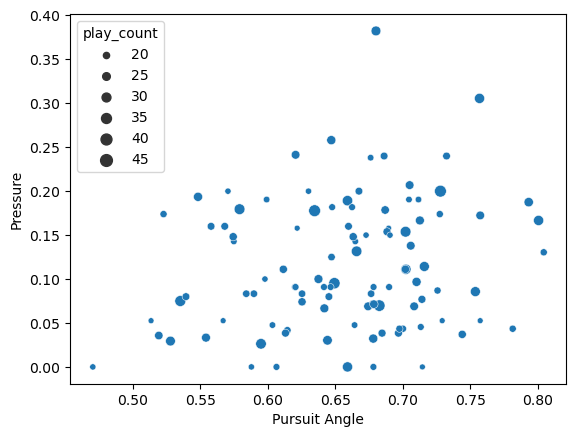

In [145]:
sns.scatterplot(data = week_metrics_grouped[week_metrics_grouped.play_count >18], x = 'Pursuit Angle', y = 'Pressure', size = 'play_count')

# V. Full half-season analysis

In [ ]:
def full_analysis():
    pass_rushers_df = acquire.scout_pass_rush()
    
    all_game_metrics = pd.DataFrame()
    
    for i in range(8):
        week_df = acquire.week(i+1)
        
        week_metrics = nf.week_analysis(week_df, pass_rushers_df)
        
        all_game_metrics = pd.concat([all_game_metrics, week_metrics])
        
    return all_game_metrics

In [ ]:
results = full_analysis()

In [ ]:
print(f'Missing 35 plays our of 8558, or {35/8558:.2}')

In [ ]:
results.sort_values(by='Metrics', ascending = False)

In [ ]:
play_count = list(results.groupby(by = 'Player').Player.count())

In [ ]:
results = results.groupby(by = 'Player').mean()

In [ ]:
results['play_count'] = play_count

In [ ]:
results.describe()

In [ ]:
results.play_count.hist(bins = 50)

In [ ]:
results.nlargest(128, columns = ['play_count'])

In [ ]:
results[results.play_count > 128].sort_values(by = 'Pressure', ascending = False)

In [ ]:
results.loc[41239]

## Altogether Now

In [ ]:
nf.full_analysis(grouped = True)